In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
def makePlots(y_test, predictions, X_test, function):
  conf_matrix = confusion_matrix(y_test, predictions)
  print('Confusion Matrix:')
  print(conf_matrix)

  plt.figure(figsize=(8, 6))
  #sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake News', 'True News'], yticklabels=['Fake News', 'True News'])
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion Matrix')
  plt.show()

  # ROC Curve
  fpr, tpr, thresholds = roc_curve(y_test, function(X_test)[:, 1])
  roc_auc = auc(fpr, tpr)

  # Plot ROC Curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.show()

#Data Loading, Prep, and Cleaning

In [4]:
#Add Path to sentiment analysis data
dataPath = 'PATH TO DATA'

In [5]:
df = pd.read_csv(dataPath, dtype={'statement': str})
dropColumns = ['Unnamed: 0', 'Unnamed: 0.1', 'tweet', 'embeddings', 'cleanedTweets', 'ampersand']
df.drop(columns=dropColumns, inplace=True)
statements = df['statement'].values
df.head()

<ipython-input-5-4a4d435f6ad3>:1: DtypeWarning: Columns (0,2,5,7,12,60,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataPath, dtype={'statement': str})


,majority_target,statement,BinaryNumTarget,followers_count,friends_count,favourites_count,statuses_count,listed_count,following,BotScore,...,determiners,conjunctions,dots,exclamation,questions,capitals,digits,long_word_freq,short_word_freq,sentiment
0,True,End of eviction moratorium means millions of A...,1.0,4262.0,3619.0,34945.0,16423.0,44.0,0.0,0.03,...,0.0,0.0,5.0,0.0,1.0,33.0,3.0,5.0,19.0,0.500000
1,True,End of eviction moratorium means millions of A...,1.0,1393.0,1621.0,31436.0,37184.0,64.0,0.0,0.03,...,0.0,2.0,1.0,0.0,0.0,14.0,0.0,2.0,34.0,0.125000
2,True,End of eviction moratorium means millions of A...,1.0,9.0,84.0,219.0,1184.0,0.0,0.0,0.03,...,0.0,1.0,0.0,0.0,0.0,3.0,0.0,4.0,10.0,0.206667
3,True,End of eviction moratorium means millions of A...,1.0,4262.0,3619.0,34945.0,16423.0,44.0,0.0,0.03,...,0.0,1.0,3.0,0.0,0.0,6.0,8.0,1.0,30.0,-0.400000
4,True,End of eviction moratorium means millions of A...,1.0,70.0,166.0,15282.0,2194.0,0.0,0.0,0.03,...,0.0,1.0,3.0,0.0,1.0,11.0,3.0,2.0,19.0,0.442857


In [6]:
statementList = []
[statementList.append(item) for item in statements if item not in statementList]
print(statementList)

['End of eviction moratorium means millions of Americans could lose their housing in the middle of a pandemic.', 'The Trump administration worked to free 5,000 Taliban prisoners.', 'In Afghanistan, over 100 billion dollars spent on military contracts.', 'A photo shows two COVID-19 patients lying on the floor awaiting treatment in Florida.', 'Its been over 50 years since minimum (wage) and inflation parted ways, then over a decade since the federal minimum went up at all.', 'We have a record 9.3 million job openings in the U.S.', 'Since 1978, CEO compensation rose over 1,000% and only 11.9% for average workers.', 'Wisconsins 2019-21 budget produced the first positive general fund balance since 2000, and the governors proposed 2021-23 budget would return it to a deficit.', 'Opposition to having a fully elected Chicago Board of Education is in the super minority.', 'We now have more job openings than we do people who are on unemployment. We have 60% more job openings today than we did the

In [7]:
grouped_df = df.groupby('statement').mean(numeric_only = True)
# Save the result to a new DataFrame
averageData = pd.DataFrame(grouped_df)
averageData.reset_index(drop=True, inplace=True)
averageData['abs_sentiment'] = abs(averageData['sentiment'])
print(averageData.shape)
averageData.head()

(1062, 59)


,BinaryNumTarget,followers_count,favourites_count,statuses_count,listed_count,following,BotScore,BotScoreBinary,cred,normalize_influence,...,conjunctions,dots,exclamation,questions,capitals,digits,long_word_freq,short_word_freq,sentiment,abs_sentiment
0,1.0,54169.500000,15100.500000,123335.900000,330.300000,0.0,0.030000,0.000000,0.693789,0.103873,...,1.000000,2.500000,0.300000,0.000000,14.600000,4.900000,2.500000,24.300000,0.237708,0.237708
1,0.0,1165.400000,7184.000000,13880.400000,2.200000,0.0,0.030000,0.000000,0.280086,0.070452,...,1.600000,4.400000,0.000000,0.000000,9.800000,4.400000,5.000000,19.800000,0.066667,0.066667
2,1.0,27638.490909,24874.536364,29435.709091,139.836364,0.0,0.046291,0.018182,0.447859,0.083699,...,0.836364,1.954545,0.300000,0.145455,12.400000,3.863636,1.872727,17.254545,0.086335,0.086335
3,1.0,42441.928571,8624.500000,51751.000000,84.714286,0.0,0.030000,0.000000,0.530045,0.088980,...,1.071429,1.857143,0.000000,0.357143,9.357143,3.071429,1.357143,20.928571,0.167873,0.167873
4,1.0,4893.500000,31514.888889,136088.444444,105.888889,0.0,0.082278,0.055556,0.461522,0.085943,...,0.888889,2.333333,0.166667,0.277778,13.500000,2.888889,1.666667,21.166667,0.163538,0.163538


In [8]:
averageData.fillna(averageData.mean(), inplace=True)

In [9]:
averageData = averageData[averageData['BinaryNumTarget'].isin([0, 1])]

In [10]:
labels = averageData['BinaryNumTarget']
averageData.drop(columns=['BinaryNumTarget'], inplace=True)
print(labels.shape)
print(averageData.shape)
averageData.head()

(1058,)
(1058, 58)


,followers_count,favourites_count,statuses_count,listed_count,following,BotScore,BotScoreBinary,cred,normalize_influence,mentions,...,conjunctions,dots,exclamation,questions,capitals,digits,long_word_freq,short_word_freq,sentiment,abs_sentiment
0,54169.500000,15100.500000,123335.900000,330.300000,0.0,0.030000,0.000000,0.693789,0.103873,0.500000,...,1.000000,2.500000,0.300000,0.000000,14.600000,4.900000,2.500000,24.300000,0.237708,0.237708
1,1165.400000,7184.000000,13880.400000,2.200000,0.0,0.030000,0.000000,0.280086,0.070452,1.000000,...,1.600000,4.400000,0.000000,0.000000,9.800000,4.400000,5.000000,19.800000,0.066667,0.066667
2,27638.490909,24874.536364,29435.709091,139.836364,0.0,0.046291,0.018182,0.447859,0.083699,1.572727,...,0.836364,1.954545,0.300000,0.145455,12.400000,3.863636,1.872727,17.254545,0.086335,0.086335
3,42441.928571,8624.500000,51751.000000,84.714286,0.0,0.030000,0.000000,0.530045,0.088980,0.357143,...,1.071429,1.857143,0.000000,0.357143,9.357143,3.071429,1.357143,20.928571,0.167873,0.167873
4,4893.500000,31514.888889,136088.444444,105.888889,0.0,0.082278,0.055556,0.461522,0.085943,1.000000,...,0.888889,2.333333,0.166667,0.277778,13.500000,2.888889,1.666667,21.166667,0.163538,0.163538


In [12]:
X_train, X_test, y_train, y_test = train_test_split(averageData, labels, test_size=0.2)

#Base Models

Accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.82        90
         1.0       0.88      0.84      0.86       122

    accuracy                           0.84       212
   macro avg       0.84      0.84      0.84       212
weighted avg       0.84      0.84      0.84       212

Confusion Matrix:
[[ 76  14]
 [ 20 102]]


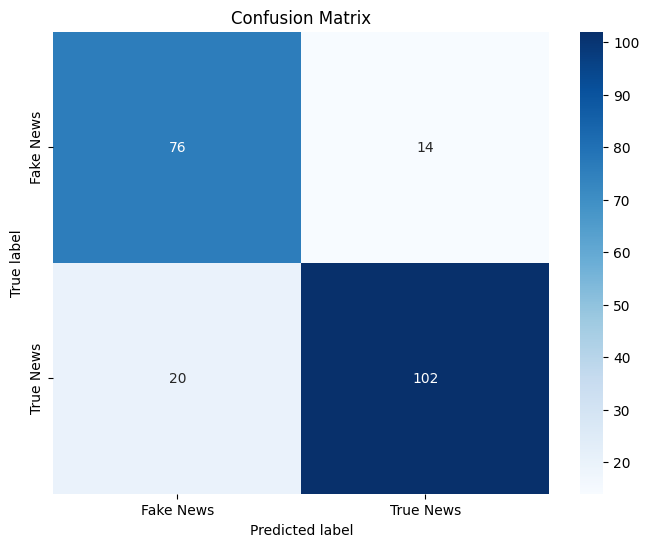

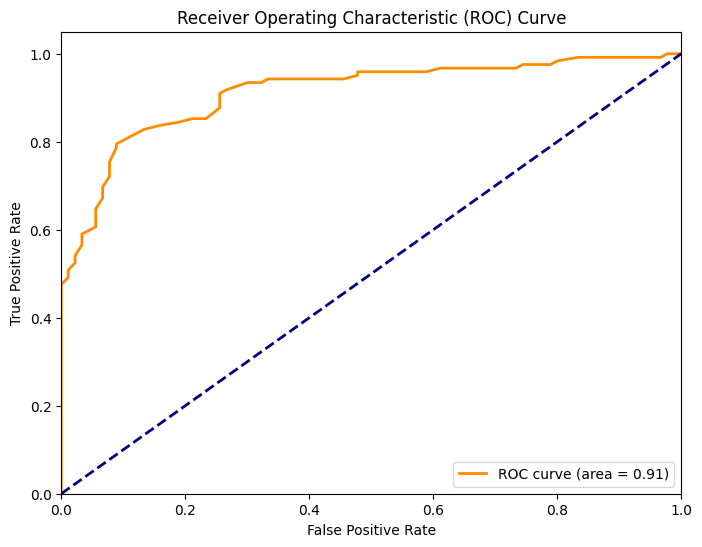

In [ ]:
# Initialize and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, predictions))

makePlots(y_test, predictions, X_test, clf.predict_proba)

Accuracy (SVM with Gaussian kernel): 0.73
Classification Report (SVM with Gaussian kernel):
              precision    recall  f1-score   support

         0.0       0.63      0.84      0.72        90
         1.0       0.85      0.64      0.73       122

    accuracy                           0.73       212
   macro avg       0.74      0.74      0.73       212
weighted avg       0.76      0.73      0.73       212

Confusion Matrix:
[[76 14]
 [44 78]]


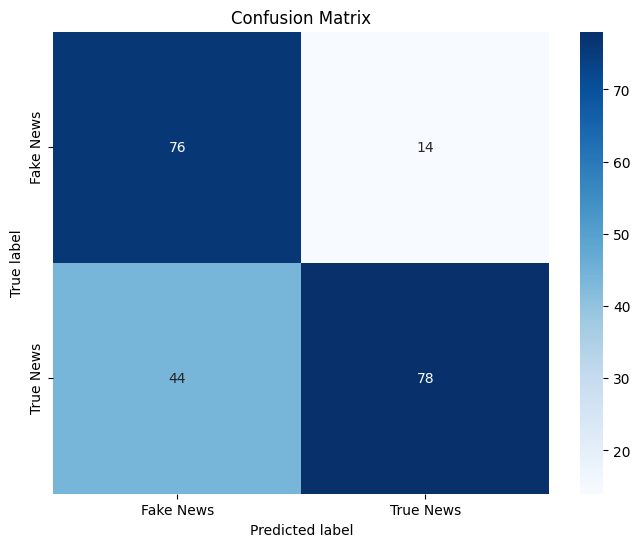

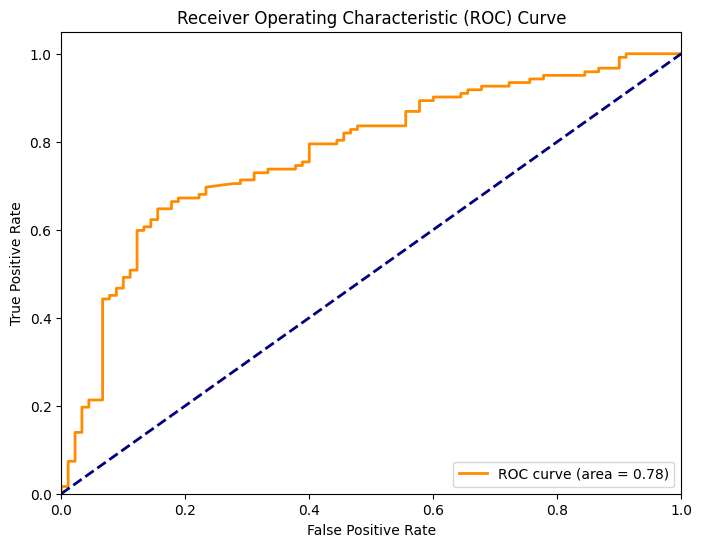

In [ ]:
# SVM with Gaussian/RBF kernel
svm_rbf = SVC(kernel='rbf', probability=True)
svm_rbf.fit(X_train, y_train)
predictions_rbf = svm_rbf.predict(X_test)
accuracy_rbf = accuracy_score(y_test, predictions_rbf)
print(f'Accuracy (SVM with Gaussian kernel): {accuracy_rbf:.2f}')
print('Classification Report (SVM with Gaussian kernel):')
print(classification_report(y_test, predictions_rbf))

makePlots(y_test, predictions_rbf, X_test, svm_rbf.predict_proba)

Accuracy (SVM with polynomial kernel): 0.65
Classification Report (SVM with polynomial kernel):
              precision    recall  f1-score   support

         0.0       0.58      0.85      0.69        96
         1.0       0.80      0.48      0.60       116

    accuracy                           0.65       212
   macro avg       0.69      0.67      0.65       212
weighted avg       0.70      0.65      0.64       212

Confusion Matrix:
[[82 14]
 [60 56]]


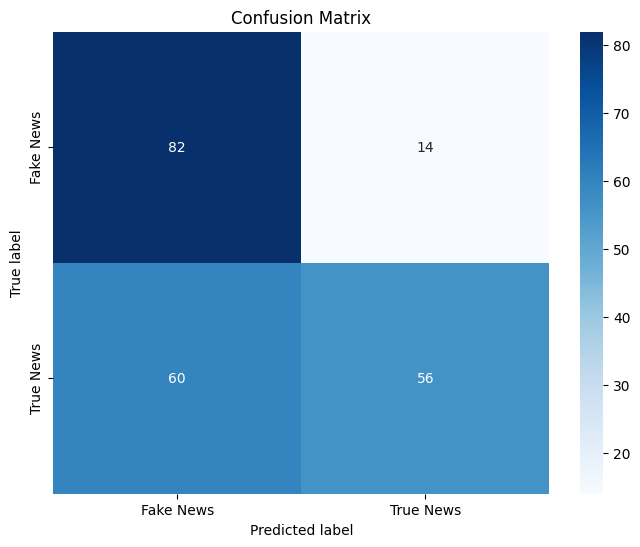

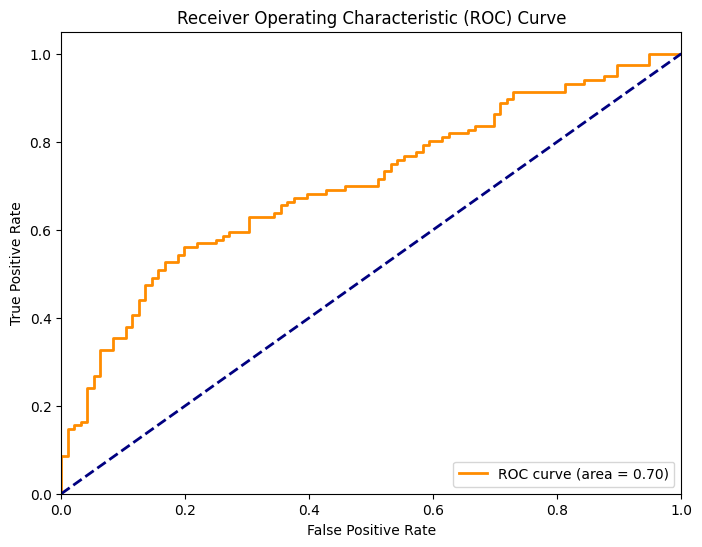

In [14]:
# SVM with Polynomial kernel
svm_poly = SVC(kernel='poly', probability=True, C=10000, degree=2)
svm_poly.fit(X_train, y_train)
predictions_poly = svm_poly.predict(X_test)
accuracy_poly = accuracy_score(y_test, predictions_poly)
print(f'Accuracy (SVM with polynomial kernel): {accuracy_poly:.2f}')
print('Classification Report (SVM with polynomial kernel):')
print(classification_report(y_test, predictions_poly))

makePlots(y_test, predictions_poly, X_test, svm_poly.predict_proba)

Accuracy (Naive Bayes): 0.57
Classification Report (Naive Bayes):
              precision    recall  f1-score   support

         0.0       0.45      0.06      0.10        90
         1.0       0.58      0.95      0.72       122

    accuracy                           0.57       212
   macro avg       0.52      0.50      0.41       212
weighted avg       0.53      0.57      0.46       212

Confusion Matrix:
[[  5  85]
 [  6 116]]


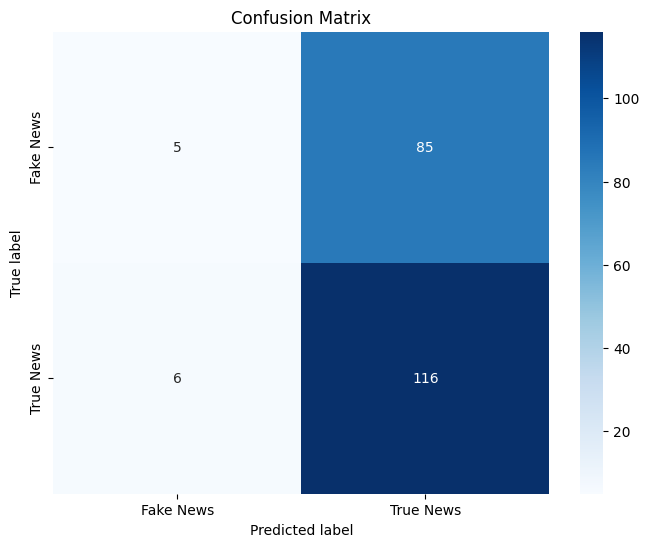

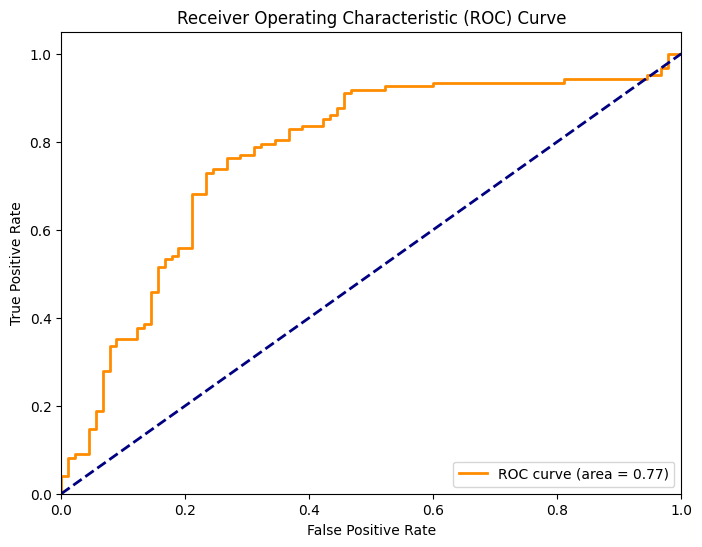

In [ ]:
# Naive Bayes classifier (Gaussian Naive Bayes for continuous features)
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Predictions and evaluation
predictions_nb = nb_classifier.predict(X_test)
accuracy_nb = accuracy_score(y_test, predictions_nb)
print(f'Accuracy (Naive Bayes): {accuracy_nb:.2f}')
print('Classification Report (Naive Bayes):')
print(classification_report(y_test, predictions_nb))

makePlots(y_test, predictions_nb, X_test, nb_classifier.predict_proba)

Accuracy (AdaBoost): 0.79
Classification Report (AdaBoost):
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76        90
         1.0       0.83      0.80      0.82       122

    accuracy                           0.79       212
   macro avg       0.79      0.79      0.79       212
weighted avg       0.79      0.79      0.79       212

Confusion Matrix:
[[70 20]
 [24 98]]


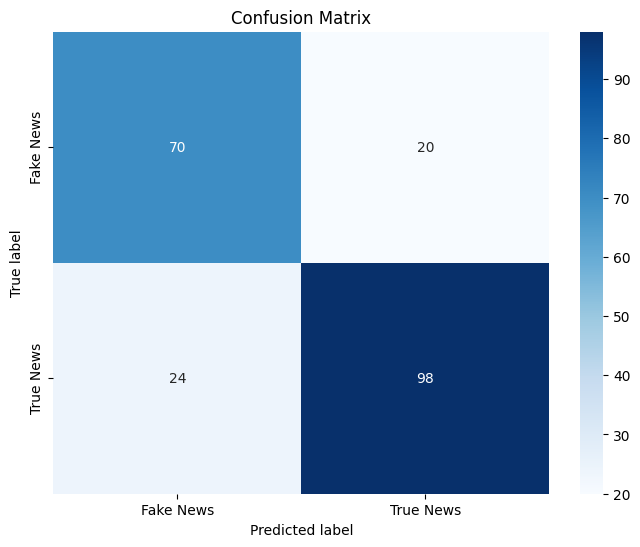

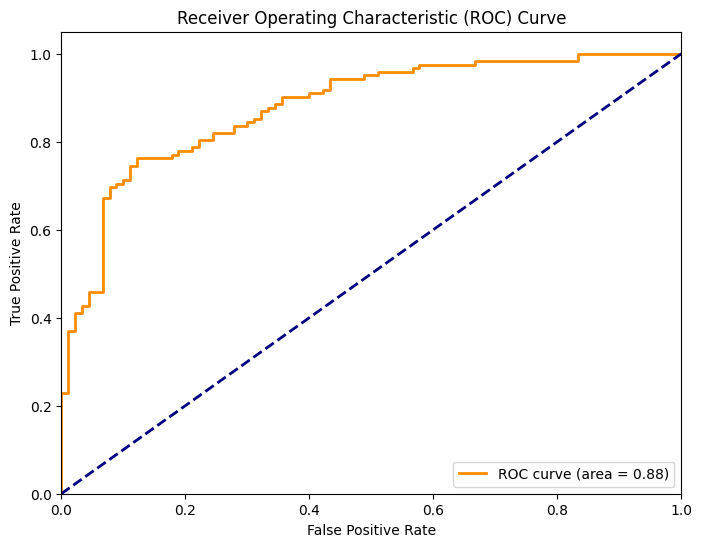

In [ ]:
# AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_classifier.fit(X_train, y_train)

# Predictions and evaluation
predictions_adaboost = adaboost_classifier.predict(X_test)
accuracy_adaboost = accuracy_score(y_test, predictions_adaboost)
print(f'Accuracy (AdaBoost): {accuracy_adaboost:.2f}')
print('Classification Report (AdaBoost):')
print(classification_report(y_test, predictions_adaboost))

makePlots(y_test, predictions_adaboost, X_test, adaboost_classifier.predict_proba)

Accuracy: 0.71
Accuracy (KNN): 0.71
Classification Report (KNN):
              precision    recall  f1-score   support

         0.0       0.64      0.72      0.68        90
         1.0       0.77      0.70      0.74       122

    accuracy                           0.71       212
   macro avg       0.71      0.71      0.71       212
weighted avg       0.72      0.71      0.71       212

Confusion Matrix:
[[65 25]
 [36 86]]


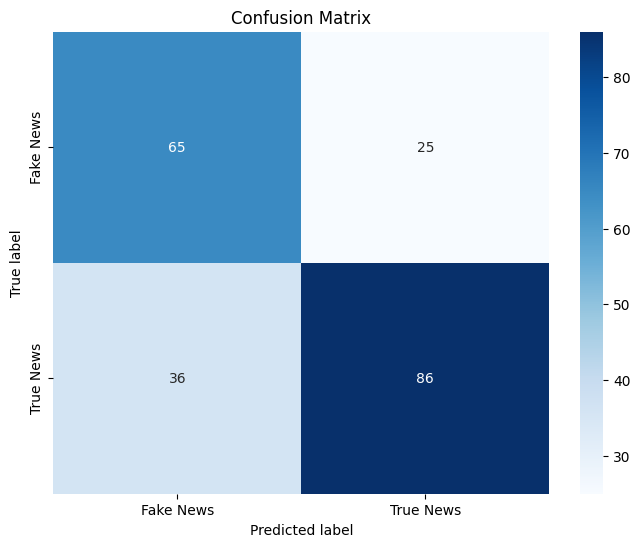

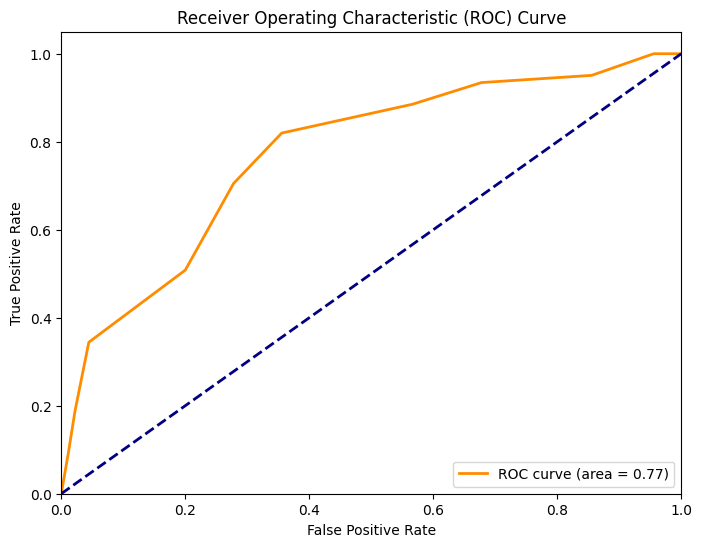

In [ ]:
#KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=10)
knn_classifier.fit(X_train, y_train)

# Predictions and evaluation
predictions_KNN = knn_classifier.predict(X_test)
accuracy_KNN = accuracy_score(y_test, predictions_KNN)
print(f'Accuracy: {accuracy_KNN:.2f}')
print(f'Accuracy (KNN): {accuracy_KNN:.2f}')
print('Classification Report (KNN):')
print(classification_report(y_test, predictions_KNN))

makePlots(y_test, predictions_KNN, X_test, knn_classifier.predict_proba)

Accuracy: 0.74
Accuracy (Logistical Regression): 0.74
Classification Report (Logistical Regression):
              precision    recall  f1-score   support

         0.0       0.66      0.77      0.71        90
         1.0       0.81      0.71      0.76       122

    accuracy                           0.74       212
   macro avg       0.73      0.74      0.73       212
weighted avg       0.75      0.74      0.74       212

Confusion Matrix:
[[69 21]
 [35 87]]


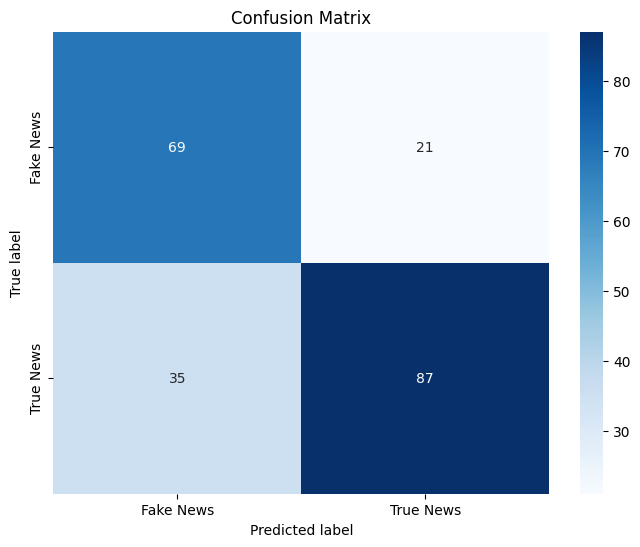

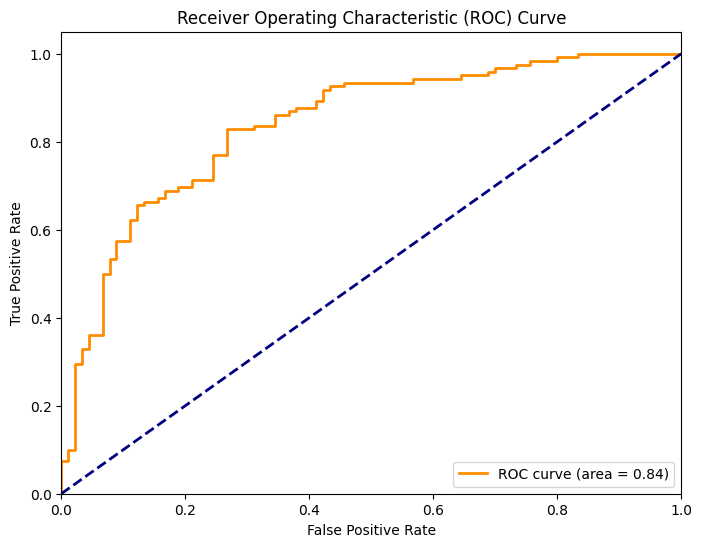

In [ ]:
#Logistical Regression Classifier
logistic_regression = LogisticRegression(max_iter=1000000)
logistic_regression.fit(X_train, y_train)

# Predictions and evaluation
predictions_log = logistic_regression.predict(X_test)
accuracy_log = accuracy_score(y_test, predictions_log)
print(f'Accuracy: {accuracy_log:.2f}')
print(f'Accuracy (Logistical Regression): {accuracy_log:.2f}')
print('Classification Report (Logistical Regression):')
print(classification_report(y_test, predictions_log))

makePlots(y_test, predictions_log, X_test, logistic_regression.predict_proba)

# Models with upsampling

In [15]:
upsampleData = averageData.copy(deep=True)

In [16]:
zeroCount = 0
oneCount = 0

for val in labels:
  if val == 1:
    oneCount += 1
  elif val == 0:
    zeroCount += 1

print(zeroCount)
print(oneCount)

479
579


In [17]:
upsampleData['tempLabel'] = labels
fakeNewsData = upsampleData[upsampleData['tempLabel'] == 0] #Needs to be upsampled
realNewsData = upsampleData[upsampleData['tempLabel'] == 1]

In [18]:
from sklearn.utils import resample
fakeNewsData = resample(fakeNewsData, replace= True, n_samples=oneCount)

fakeNewsData.shape

(579, 59)

In [19]:
upsampleData = pd.concat([fakeNewsData, realNewsData], ignore_index=True)
upsampleData.drop('tempLabel', axis=1, inplace=True)
print(upsampleData.shape)
upsampleData.head()

(1158, 58)


,followers_count,favourites_count,statuses_count,listed_count,following,BotScore,BotScoreBinary,cred,normalize_influence,mentions,...,conjunctions,dots,exclamation,questions,capitals,digits,long_word_freq,short_word_freq,sentiment,abs_sentiment
0,2603.794258,33287.566986,29363.760766,33.258373,0.0,0.037926,0.009569,0.428628,0.079093,1.964115,...,0.866029,1.944976,0.136364,0.095694,7.246411,2.375598,1.873206,17.531100,0.085480,0.085480
1,5521.578947,25112.105263,23392.421053,10.315789,0.0,0.030000,0.000000,0.463597,0.087328,0.578947,...,1.894737,2.842105,0.105263,0.421053,16.000000,1.105263,2.526316,24.684211,-0.023264,0.023264
2,336.238095,15917.285714,11170.095238,3.619048,0.0,0.030000,0.000000,0.218234,0.062179,0.857143,...,0.952381,1.523810,0.095238,0.142857,6.714286,0.666667,1.238095,17.857143,-0.063806,0.063806
3,528.000000,33484.000000,10316.000000,5.000000,0.0,0.030000,0.000000,0.128155,0.083343,2.000000,...,0.000000,5.000000,0.000000,0.000000,8.000000,6.000000,3.000000,28.000000,0.000000,0.000000
4,1997.658228,28778.130802,22831.835443,16.196203,0.0,0.061203,0.035865,0.325893,0.067631,1.584388,...,2.187764,2.297468,0.535865,0.506329,16.890295,1.635021,2.080169,25.449367,0.015399,0.015399


In [20]:
labelData = [0] * 579 + [1] * 579

In [21]:
X_train, X_test, y_train, y_test = train_test_split(upsampleData, labelData, test_size=0.2)

Accuracy: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       117
           1       0.93      0.86      0.89       115

    accuracy                           0.90       232
   macro avg       0.90      0.90      0.90       232
weighted avg       0.90      0.90      0.90       232

Confusion Matrix:
[[109   8]
 [ 16  99]]


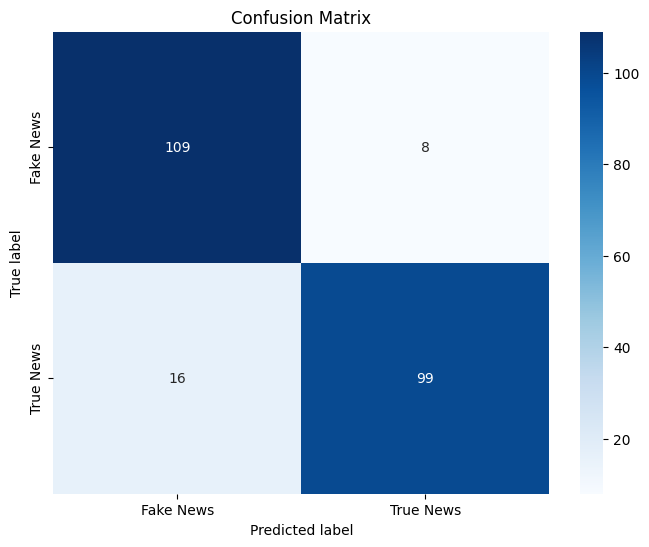

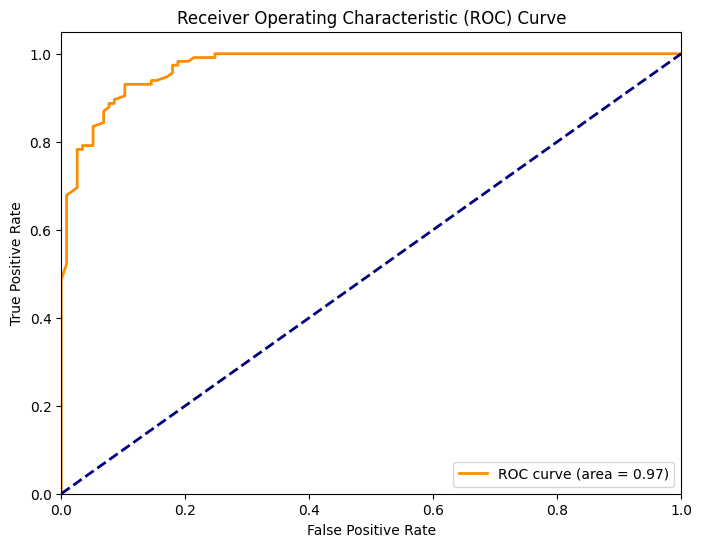

In [22]:
# Initialize and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, predictions))

makePlots(y_test, predictions, X_test, clf.predict_proba)

Accuracy (SVM with Gaussian kernel): 0.63
Classification Report (SVM with Gaussian kernel):
              precision    recall  f1-score   support

           0       0.57      0.85      0.68       110
           1       0.76      0.43      0.55       122

    accuracy                           0.63       232
   macro avg       0.67      0.64      0.62       232
weighted avg       0.67      0.63      0.61       232

Confusion Matrix:
[[93 17]
 [69 53]]


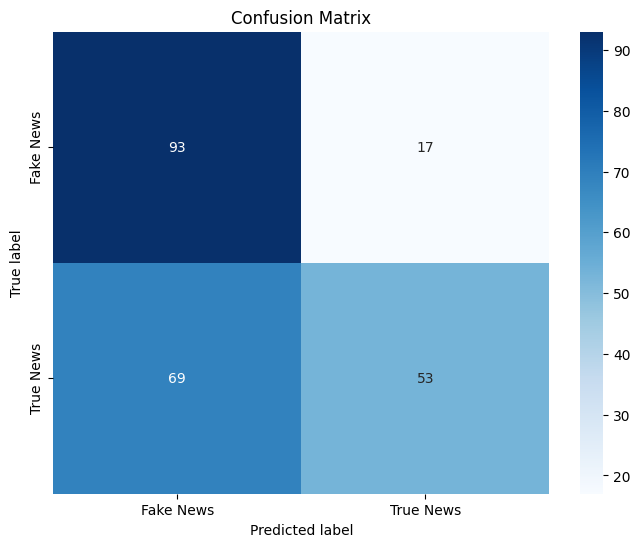

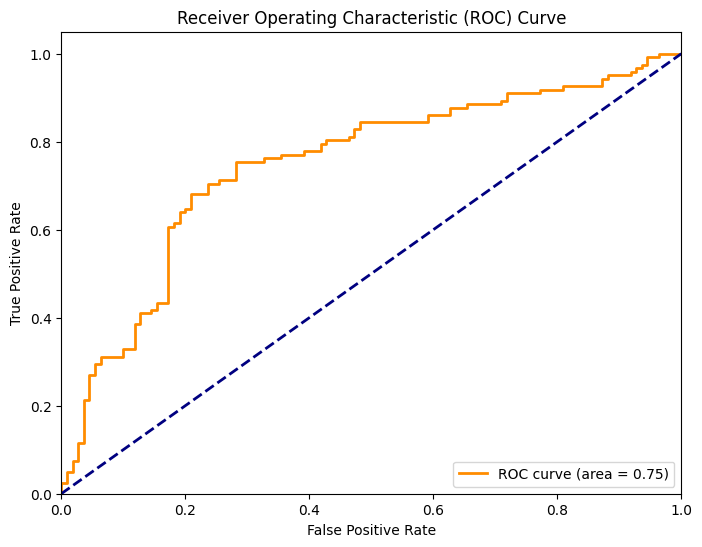

In [ ]:
# SVM with Gaussian/RBF kernel
svm_rbf = SVC(kernel='rbf', probability=True)
svm_rbf.fit(X_train, y_train)
predictions_rbf = svm_rbf.predict(X_test)
accuracy_rbf = accuracy_score(y_test, predictions_rbf)
print(f'Accuracy (SVM with Gaussian kernel): {accuracy_rbf:.2f}')
print('Classification Report (SVM with Gaussian kernel):')
print(classification_report(y_test, predictions_rbf))

makePlots(y_test, predictions_rbf, X_test, svm_rbf.predict_proba)

Accuracy (SVM with polynomial kernel): 0.68
Classification Report (SVM with polynomial kernel):
              precision    recall  f1-score   support

           0       0.63      0.87      0.73       117
           1       0.79      0.48      0.59       115

    accuracy                           0.68       232
   macro avg       0.71      0.68      0.66       232
weighted avg       0.71      0.68      0.66       232

Confusion Matrix:
[[102  15]
 [ 60  55]]


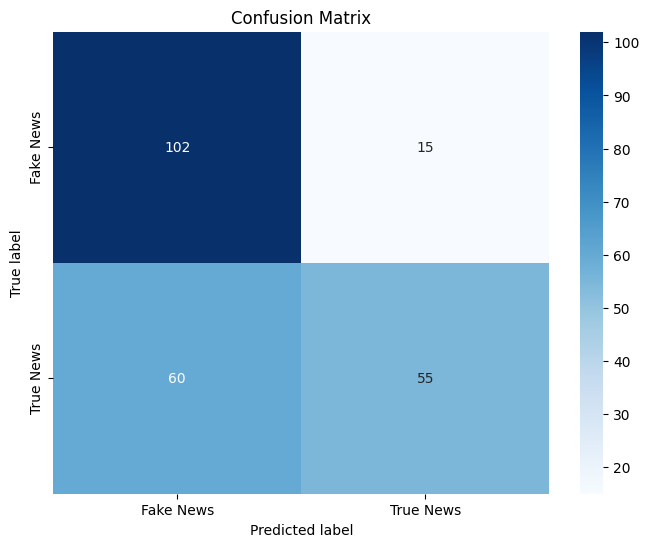

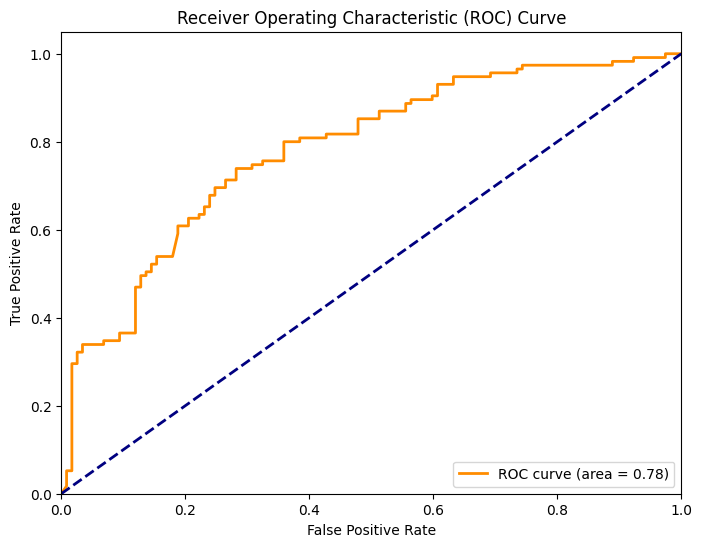

In [23]:
# SVM with Polynomial kernel
svm_poly = SVC(kernel='poly', probability=True, C=10000, degree=2)
svm_poly.fit(X_train, y_train)
predictions_poly = svm_poly.predict(X_test)
accuracy_poly = accuracy_score(y_test, predictions_poly)
print(f'Accuracy (SVM with polynomial kernel): {accuracy_poly:.2f}')
print('Classification Report (SVM with polynomial kernel):')
print(classification_report(y_test, predictions_poly))

makePlots(y_test, predictions_poly, X_test, svm_poly.predict_proba)

Accuracy (Naive Bayes): 0.56
Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.73      0.10      0.18       110
           1       0.54      0.97      0.70       122

    accuracy                           0.56       232
   macro avg       0.64      0.53      0.44       232
weighted avg       0.63      0.56      0.45       232

Confusion Matrix:
[[ 11  99]
 [  4 118]]


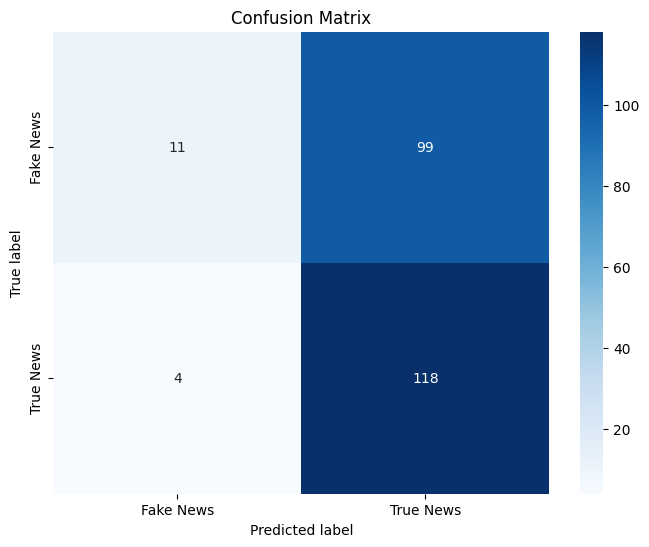

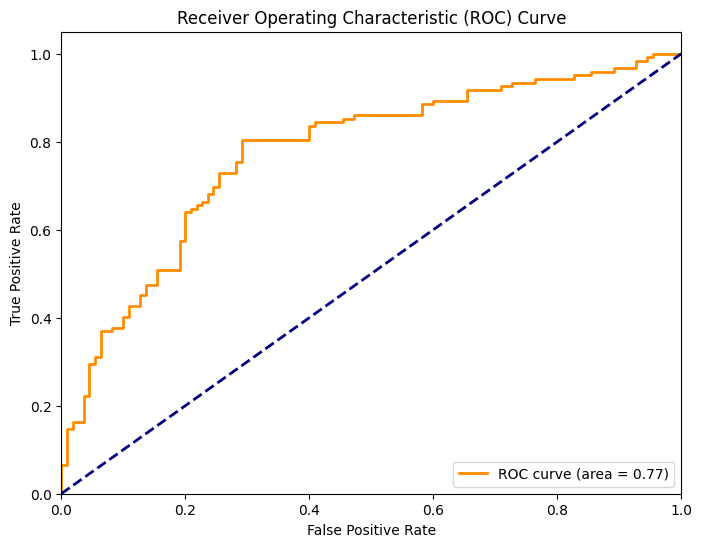

In [ ]:
# Naive Bayes classifier (Gaussian Naive Bayes for continuous features)
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Predictions and evaluation
predictions_nb = nb_classifier.predict(X_test)
accuracy_nb = accuracy_score(y_test, predictions_nb)
print(f'Accuracy (Naive Bayes): {accuracy_nb:.2f}')
print('Classification Report (Naive Bayes):')
print(classification_report(y_test, predictions_nb))

makePlots(y_test, predictions_nb, X_test, nb_classifier.predict_proba)

Accuracy (AdaBoost): 0.88
Classification Report (AdaBoost):
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       110
           1       0.91      0.85      0.88       122

    accuracy                           0.88       232
   macro avg       0.88      0.88      0.88       232
weighted avg       0.88      0.88      0.88       232

Confusion Matrix:
[[100  10]
 [ 18 104]]


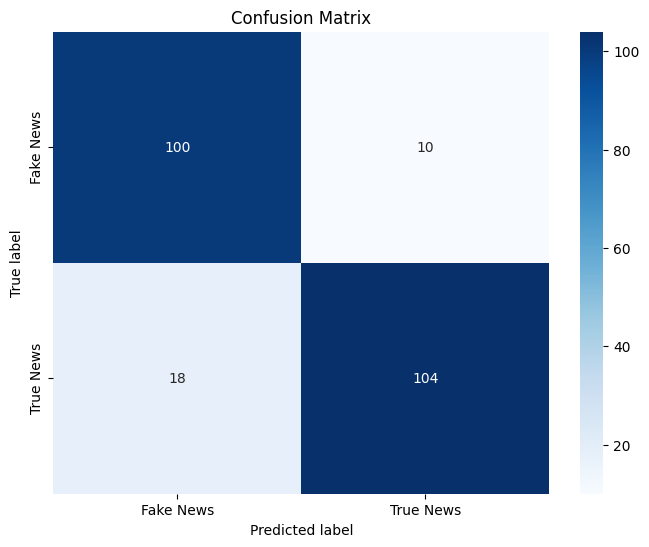

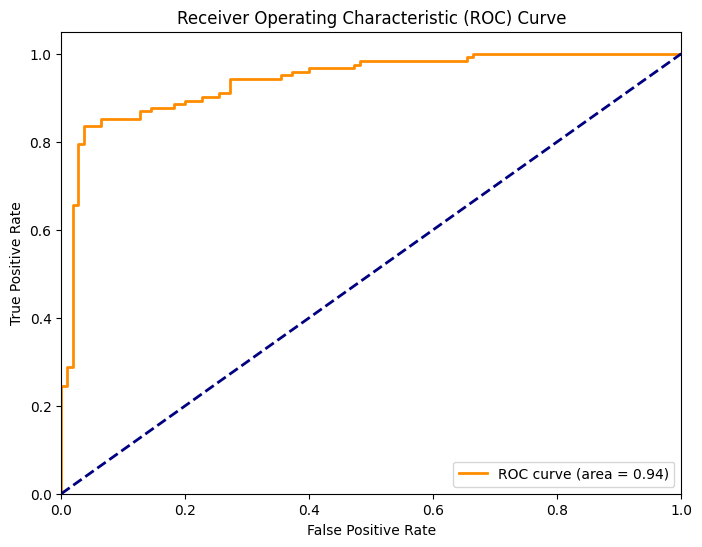

In [ ]:
# AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_classifier.fit(X_train, y_train)

# Predictions and evaluation
predictions_adaboost = adaboost_classifier.predict(X_test)
accuracy_adaboost = accuracy_score(y_test, predictions_adaboost)
print(f'Accuracy (AdaBoost): {accuracy_adaboost:.2f}')
print('Classification Report (AdaBoost):')
print(classification_report(y_test, predictions_adaboost))

makePlots(y_test, predictions_adaboost, X_test, adaboost_classifier.predict_proba)

Accuracy: 0.66
Accuracy (KNN): 0.66
Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.60      0.79      0.69       110
           1       0.74      0.53      0.62       122

    accuracy                           0.66       232
   macro avg       0.67      0.66      0.65       232
weighted avg       0.67      0.66      0.65       232

Confusion Matrix:
[[87 23]
 [57 65]]


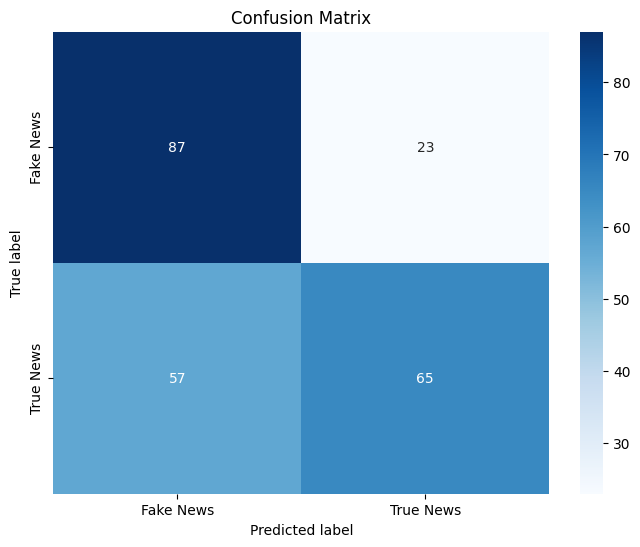

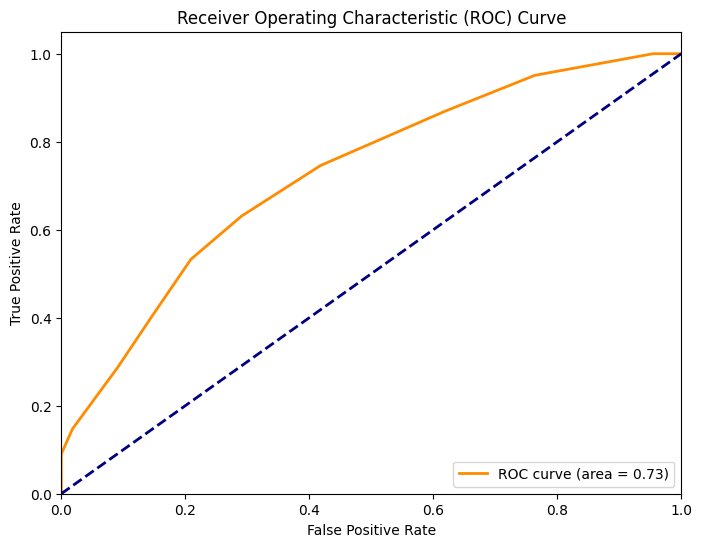

In [ ]:
#KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=10)
knn_classifier.fit(X_train, y_train)

# Predictions and evaluation
predictions_KNN = knn_classifier.predict(X_test)
accuracy_KNN = accuracy_score(y_test, predictions_KNN)
print(f'Accuracy: {accuracy_KNN:.2f}')
print(f'Accuracy (KNN): {accuracy_KNN:.2f}')
print('Classification Report (KNN):')
print(classification_report(y_test, predictions_KNN))

makePlots(y_test, predictions_KNN, X_test, knn_classifier.predict_proba)

Accuracy: 0.75
Accuracy (Logistical Regression): 0.75
Classification Report (Logistical Regression):
              precision    recall  f1-score   support

           0       0.69      0.85      0.76       110
           1       0.83      0.66      0.73       122

    accuracy                           0.75       232
   macro avg       0.76      0.76      0.75       232
weighted avg       0.77      0.75      0.75       232

Confusion Matrix:
[[94 16]
 [42 80]]


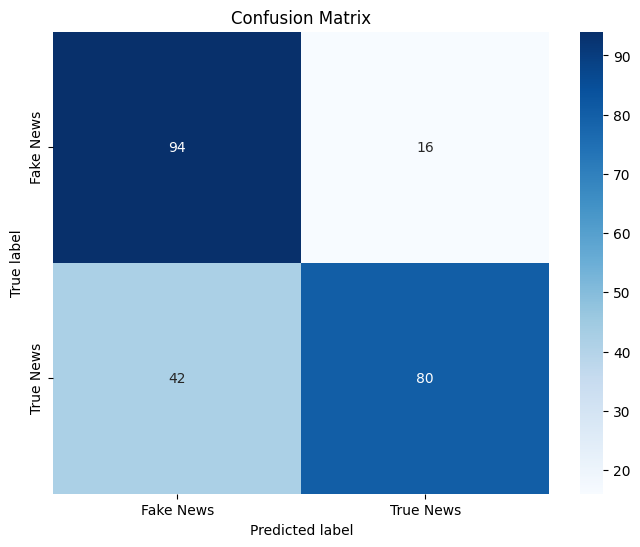

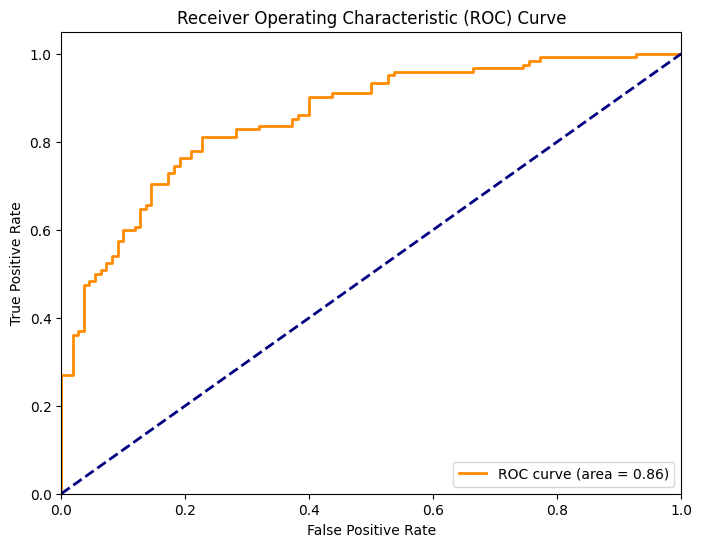

In [ ]:
#Logistical Regression Classifier
logistic_regression = LogisticRegression(max_iter=1000000)
logistic_regression.fit(X_train, y_train)

# Predictions and evaluation
predictions_log = logistic_regression.predict(X_test)
accuracy_log = accuracy_score(y_test, predictions_log)
print(f'Accuracy: {accuracy_log:.2f}')
print(f'Accuracy (Logistical Regression): {accuracy_log:.2f}')
print('Classification Report (Logistical Regression):')
print(classification_report(y_test, predictions_log))

makePlots(y_test, predictions_log, X_test, logistic_regression.predict_proba)

#Models with PCA

In [27]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [28]:
df = averageData.copy(deep=True)

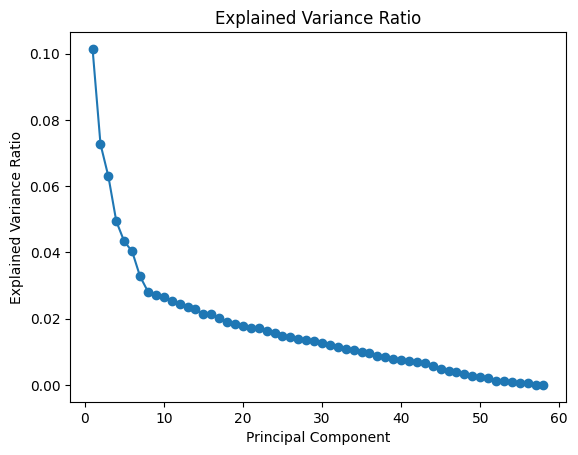

In [29]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Create a dataframe with the principal components
columns = [f'PC{i+1}' for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(data=pca_result, columns=columns)

# Print the explained variance ratio
#print("Explained Variance Ratio:")
#print(pca.explained_variance_ratio_)

# Plot the explained variance ratio
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [30]:
# Set a threshold for cumulative explained variance
cumulative_variance_threshold = 0.6

# Find the number of components needed to meet the threshold
cumulative_variance = 0
num_components_to_keep = 0

for i, variance_ratio in enumerate(pca.explained_variance_ratio_):
    cumulative_variance += variance_ratio
    num_components_to_keep += 1
    if cumulative_variance >= cumulative_variance_threshold:
        break

# Use only the selected number of components
pca = PCA(n_components=num_components_to_keep)
pca_result = pca.fit_transform(scaled_data)

# Create a dataframe with the selected principal components
columns = [f'PC{i+1}' for i in range(num_components_to_keep)]
pca_df = pd.DataFrame(data=pca_result, columns=columns)

# Print the updated number of components
print(f"Number of components selected: {num_components_to_keep}")

# Display the new dataframe
print("Dataframe with Principal Components:")
pca_df.shape

Number of components selected: 15
Dataframe with Principal Components:


(1058, 15)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(pca_df, labels, test_size=0.2)

Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.84      0.78       100
         1.0       0.84      0.72      0.78       112

    accuracy                           0.78       212
   macro avg       0.78      0.78      0.78       212
weighted avg       0.79      0.78      0.78       212

Confusion Matrix:
[[84 16]
 [31 81]]


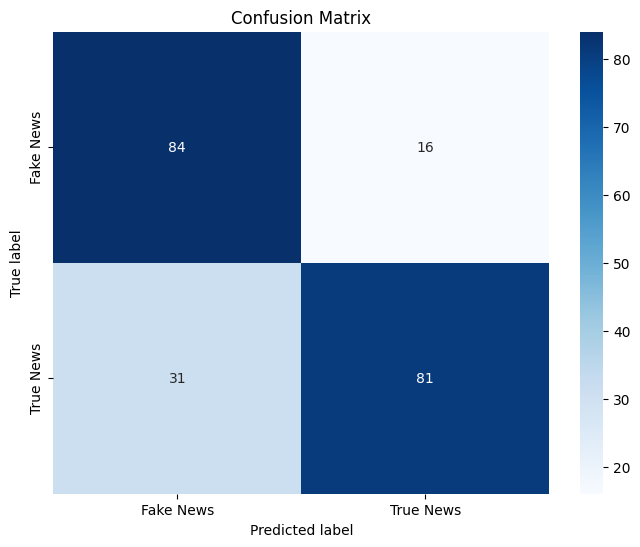

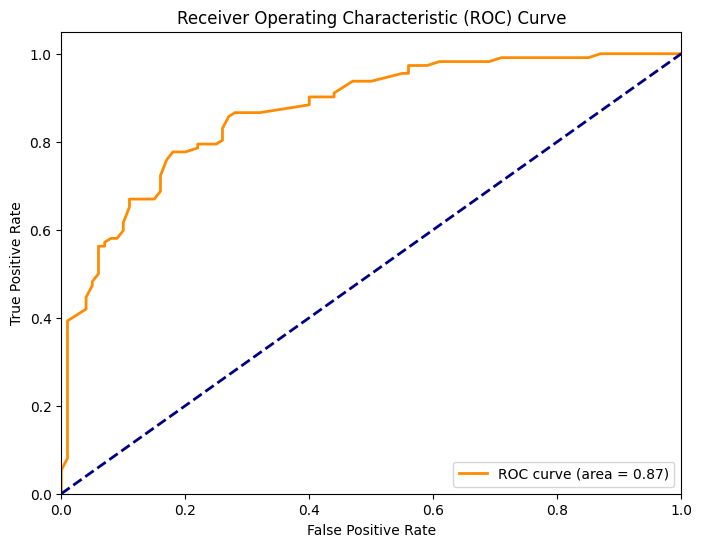

In [ ]:
# Initialize and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, predictions))

makePlots(y_test, predictions, X_test, clf.predict_proba)

Accuracy (SVM with Gaussian kernel): 0.77
Classification Report (SVM with Gaussian kernel):
              precision    recall  f1-score   support

         0.0       0.73      0.80      0.77       100
         1.0       0.81      0.74      0.77       112

    accuracy                           0.77       212
   macro avg       0.77      0.77      0.77       212
weighted avg       0.77      0.77      0.77       212

Confusion Matrix:
[[80 20]
 [29 83]]


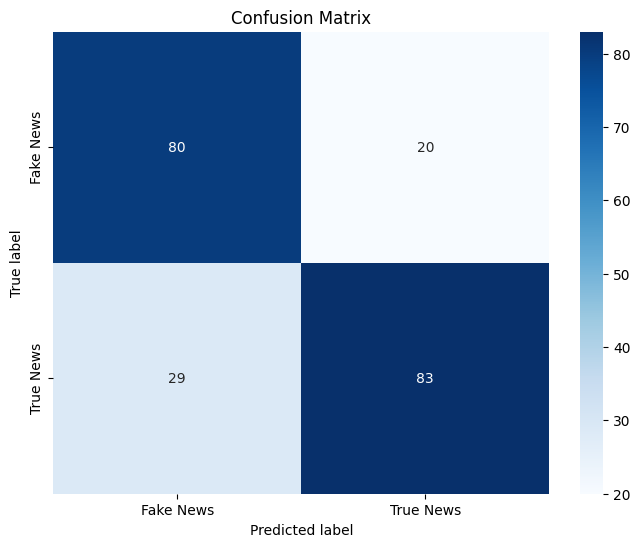

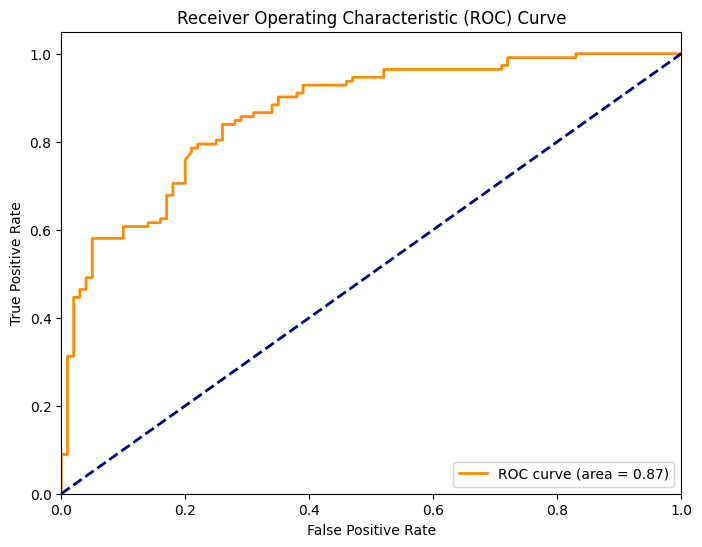

In [ ]:
# SVM with Gaussian/RBF kernel
svm_rbf = SVC(kernel='rbf', probability=True)
svm_rbf.fit(X_train, y_train)
predictions_rbf = svm_rbf.predict(X_test)
accuracy_rbf = accuracy_score(y_test, predictions_rbf)
print(f'Accuracy (SVM with Gaussian kernel): {accuracy_rbf:.2f}')
print('Classification Report (SVM with Gaussian kernel):')
print(classification_report(y_test, predictions_rbf))

makePlots(y_test, predictions_rbf, X_test, svm_rbf.predict_proba)

Accuracy (SVM with polynomial kernel): 0.70
Classification Report (SVM with polynomial kernel):
              precision    recall  f1-score   support

         0.0       0.71      0.62      0.66       100
         1.0       0.70      0.78      0.73       112

    accuracy                           0.70       212
   macro avg       0.70      0.70      0.70       212
weighted avg       0.70      0.70      0.70       212

Confusion Matrix:
[[62 38]
 [25 87]]


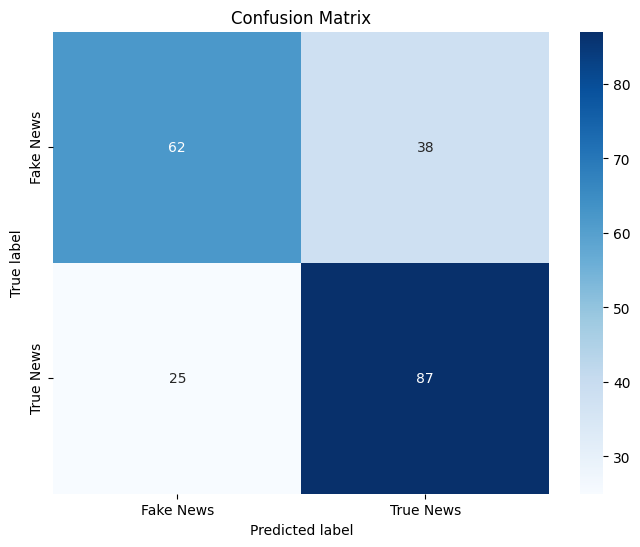

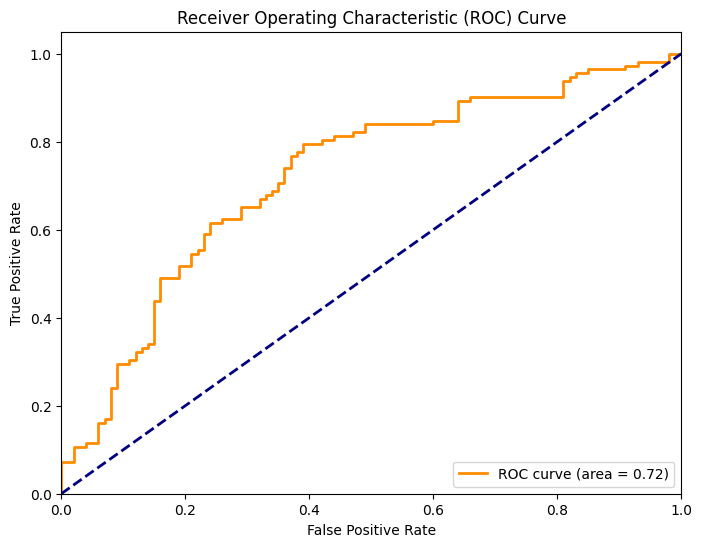

In [32]:
# SVM with Polynomial kernel
svm_poly = SVC(kernel='poly', probability=True, C=10000, degree=2)
svm_poly.fit(X_train, y_train)
predictions_poly = svm_poly.predict(X_test)
accuracy_poly = accuracy_score(y_test, predictions_poly)
print(f'Accuracy (SVM with polynomial kernel): {accuracy_poly:.2f}')
print('Classification Report (SVM with polynomial kernel):')
print(classification_report(y_test, predictions_poly))

makePlots(y_test, predictions_poly, X_test, svm_poly.predict_proba)

Accuracy (Naive Bayes): 0.67
Classification Report (Naive Bayes):
              precision    recall  f1-score   support

         0.0       0.67      0.60      0.63       100
         1.0       0.67      0.73      0.70       112

    accuracy                           0.67       212
   macro avg       0.67      0.67      0.67       212
weighted avg       0.67      0.67      0.67       212

Confusion Matrix:
[[60 40]
 [30 82]]


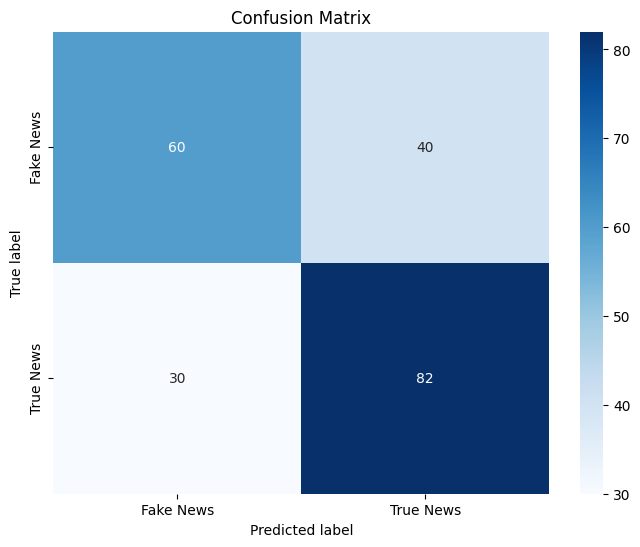

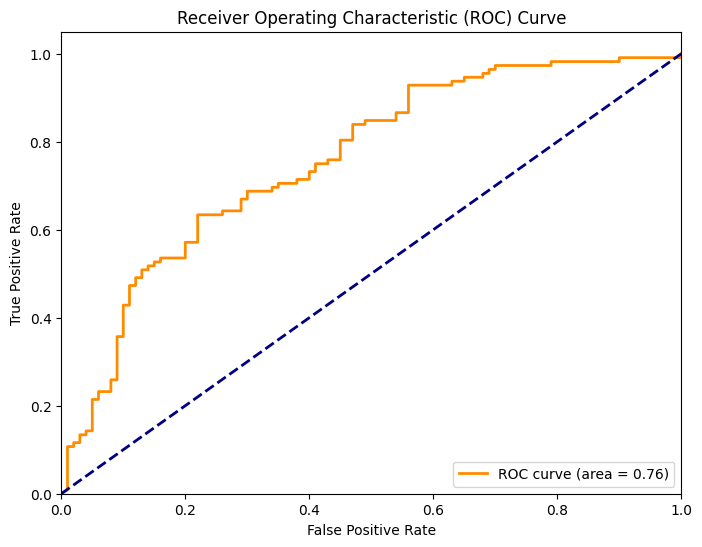

In [ ]:
# Naive Bayes classifier (Gaussian Naive Bayes for continuous features)
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Predictions and evaluation
predictions_nb = nb_classifier.predict(X_test)
accuracy_nb = accuracy_score(y_test, predictions_nb)
print(f'Accuracy (Naive Bayes): {accuracy_nb:.2f}')
print('Classification Report (Naive Bayes):')
print(classification_report(y_test, predictions_nb))

makePlots(y_test, predictions_nb, X_test, nb_classifier.predict_proba)

Accuracy (AdaBoost): 0.74
Classification Report (AdaBoost):
              precision    recall  f1-score   support

         0.0       0.72      0.73      0.72       100
         1.0       0.75      0.74      0.75       112

    accuracy                           0.74       212
   macro avg       0.74      0.74      0.74       212
weighted avg       0.74      0.74      0.74       212

Confusion Matrix:
[[73 27]
 [29 83]]


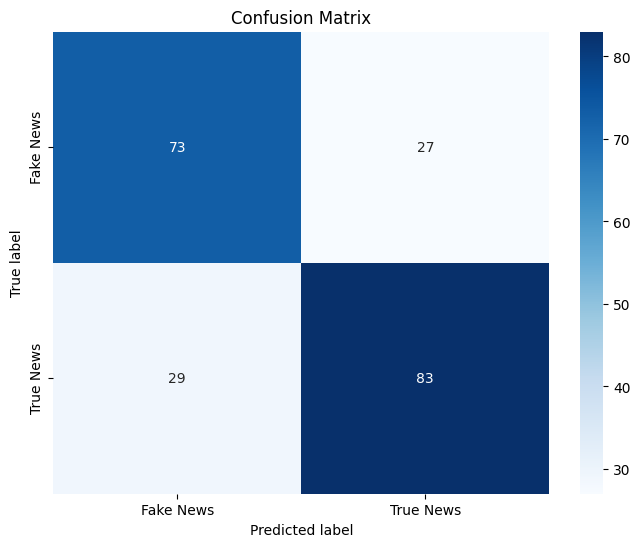

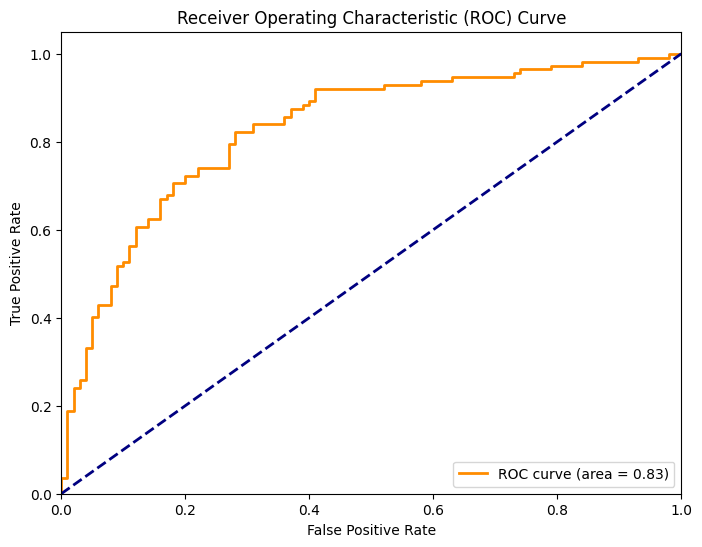

In [ ]:
# AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_classifier.fit(X_train, y_train)

# Predictions and evaluation
predictions_adaboost = adaboost_classifier.predict(X_test)
accuracy_adaboost = accuracy_score(y_test, predictions_adaboost)
print(f'Accuracy (AdaBoost): {accuracy_adaboost:.2f}')
print('Classification Report (AdaBoost):')
print(classification_report(y_test, predictions_adaboost))

makePlots(y_test, predictions_adaboost, X_test, adaboost_classifier.predict_proba)

Accuracy: 0.75
Accuracy (KNN): 0.75
Classification Report (KNN):
              precision    recall  f1-score   support

         0.0       0.72      0.78      0.75       100
         1.0       0.79      0.73      0.76       112

    accuracy                           0.75       212
   macro avg       0.76      0.76      0.75       212
weighted avg       0.76      0.75      0.75       212

Confusion Matrix:
[[78 22]
 [30 82]]


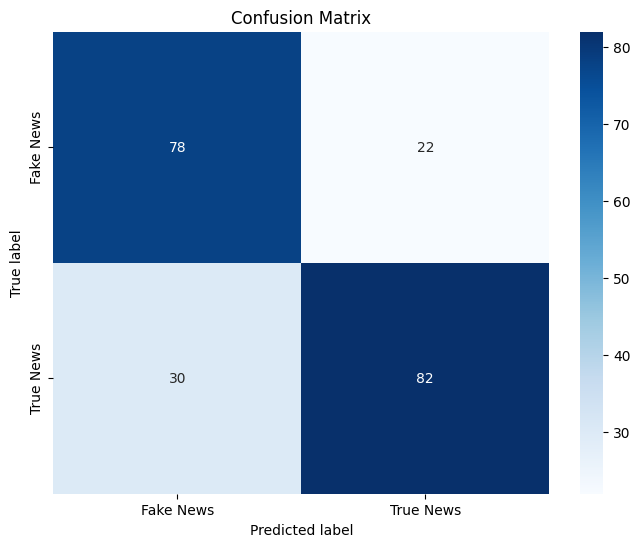

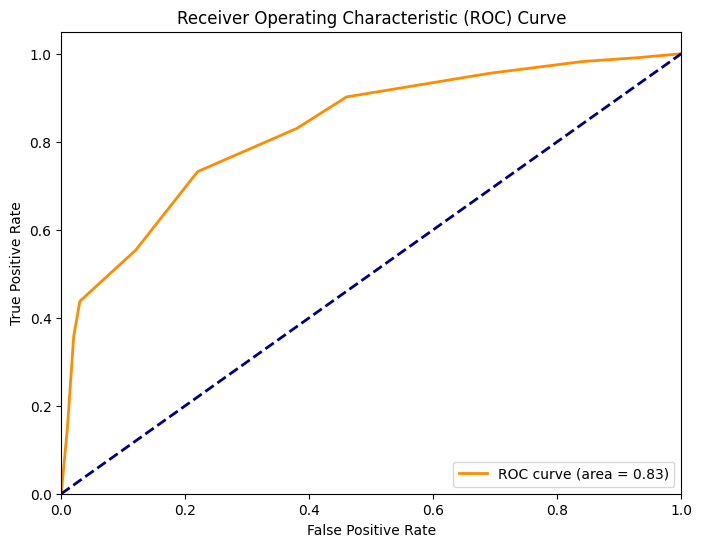

In [ ]:
#KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=10)
knn_classifier.fit(X_train, y_train)

# Predictions and evaluation
predictions_KNN = knn_classifier.predict(X_test)
accuracy_KNN = accuracy_score(y_test, predictions_KNN)
print(f'Accuracy: {accuracy_KNN:.2f}')
print(f'Accuracy (KNN): {accuracy_KNN:.2f}')
print('Classification Report (KNN):')
print(classification_report(y_test, predictions_KNN))

makePlots(y_test, predictions_KNN, X_test, knn_classifier.predict_proba)

Accuracy: 0.74
Accuracy (Logistical Regression): 0.74
Classification Report (Logistical Regression):
              precision    recall  f1-score   support

         0.0       0.70      0.78      0.74       100
         1.0       0.78      0.71      0.74       112

    accuracy                           0.74       212
   macro avg       0.74      0.74      0.74       212
weighted avg       0.74      0.74      0.74       212

Confusion Matrix:
[[78 22]
 [33 79]]


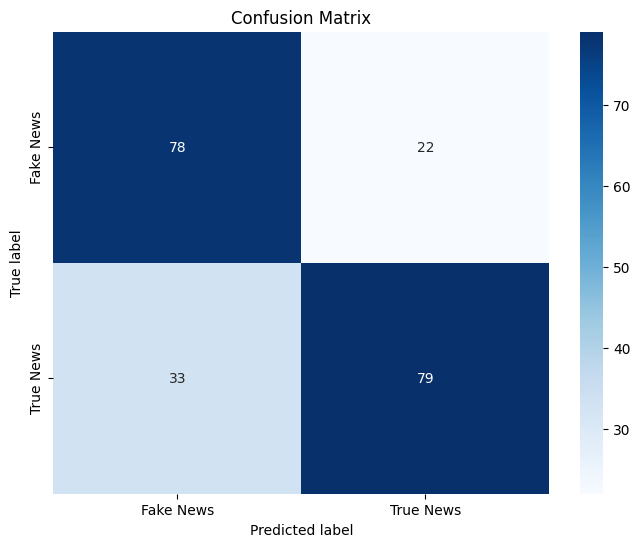

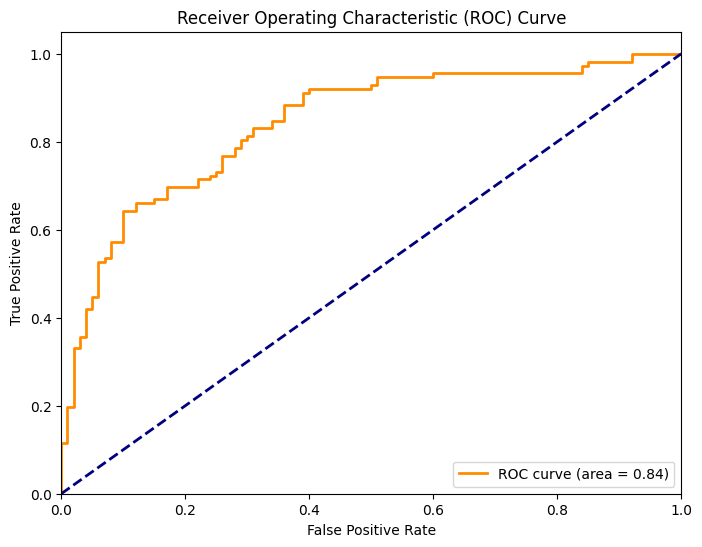

In [ ]:
#Logistical Regression Classifier
logistic_regression = LogisticRegression(max_iter=1000000)
logistic_regression.fit(X_train, y_train)

# Predictions and evaluation
predictions_log = logistic_regression.predict(X_test)
accuracy_log = accuracy_score(y_test, predictions_log)
print(f'Accuracy: {accuracy_log:.2f}')
print(f'Accuracy (Logistical Regression): {accuracy_log:.2f}')
print('Classification Report (Logistical Regression):')
print(classification_report(y_test, predictions_log))

makePlots(y_test, predictions_log, X_test, logistic_regression.predict_proba)

#Models with upsampling and PCA

In [33]:
upsamplePCAData = upsampleData.copy(deep=True)

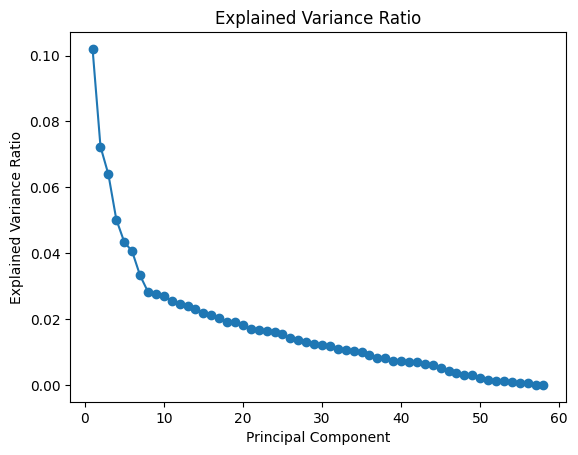

In [34]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(upsamplePCAData)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Create a dataframe with the principal components
columns = [f'PC{i+1}' for i in range(pca_result.shape[1])]
pca_df = pd.DataFrame(data=pca_result, columns=columns)

# Print the explained variance ratio
#print("Explained Variance Ratio:")
#print(pca.explained_variance_ratio_)

# Plot the explained variance ratio
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [35]:
# Set a threshold for cumulative explained variance
cumulative_variance_threshold = 0.6

# Find the number of components needed to meet the threshold
cumulative_variance = 0
num_components_to_keep = 0

for i, variance_ratio in enumerate(pca.explained_variance_ratio_):
    cumulative_variance += variance_ratio
    num_components_to_keep += 1
    if cumulative_variance >= cumulative_variance_threshold:
        break

# Use only the selected number of components
pca = PCA(n_components=num_components_to_keep)
pca_result = pca.fit_transform(scaled_data)

# Create a dataframe with the selected principal components
columns = [f'PC{i+1}' for i in range(num_components_to_keep)]
pca_df_up = pd.DataFrame(data=pca_result, columns=columns)

# Print the updated number of components
print(f"Number of components selected: {num_components_to_keep}")

# Display the new dataframe
print("Dataframe with Principal Components:")
pca_df_up.shape

Number of components selected: 15
Dataframe with Principal Components:


(1158, 15)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(pca_df_up, labelData, test_size=0.2)

Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       108
           1       0.91      0.85      0.88       124

    accuracy                           0.88       232
   macro avg       0.88      0.88      0.88       232
weighted avg       0.88      0.88      0.88       232

Confusion Matrix:
[[ 98  10]
 [ 18 106]]


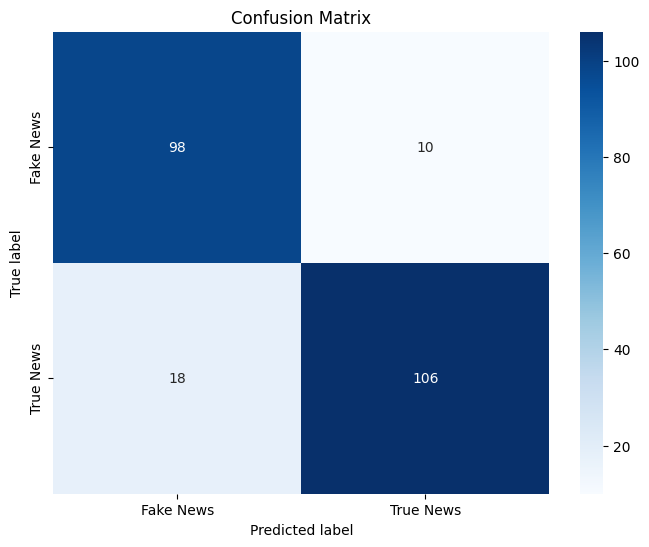

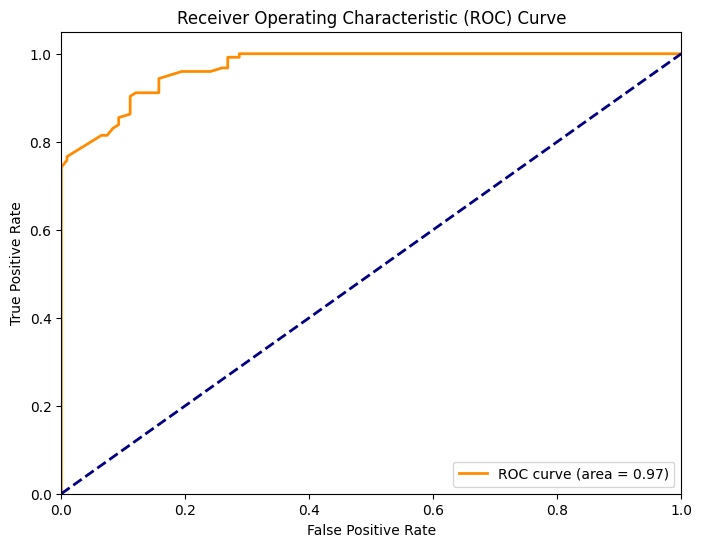

In [ ]:
# Initialize and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, predictions))

makePlots(y_test, predictions, X_test, clf.predict_proba)

Accuracy (SVM with Gaussian kernel): 0.85
Classification Report (SVM with Gaussian kernel):
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       108
           1       0.89      0.83      0.86       124

    accuracy                           0.85       232
   macro avg       0.85      0.86      0.85       232
weighted avg       0.86      0.85      0.85       232

Confusion Matrix:
[[ 95  13]
 [ 21 103]]


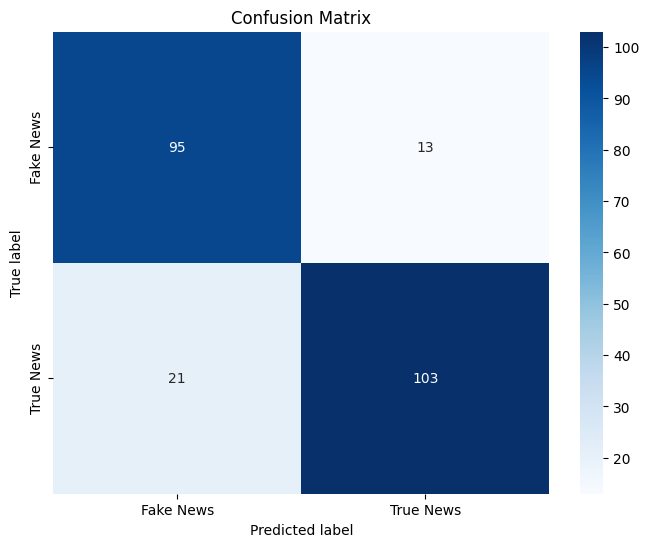

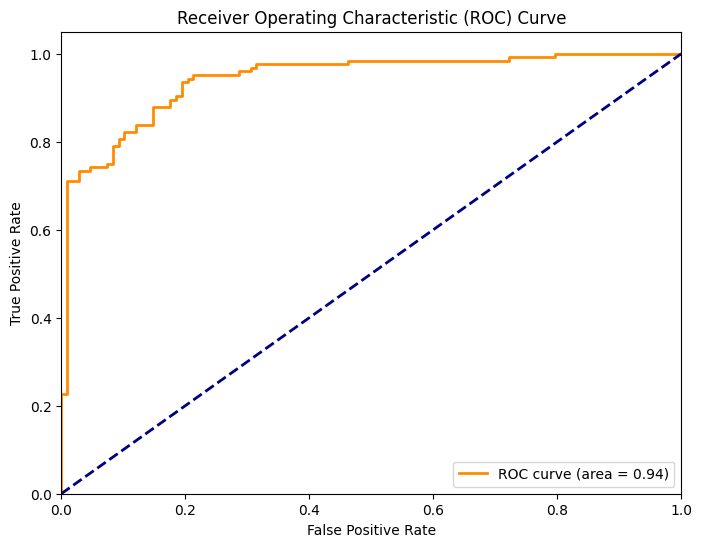

In [ ]:
# SVM with Gaussian/RBF kernel
svm_rbf = SVC(kernel='rbf', probability=True)
svm_rbf.fit(X_train, y_train)
predictions_rbf = svm_rbf.predict(X_test)
accuracy_rbf = accuracy_score(y_test, predictions_rbf)
print(f'Accuracy (SVM with Gaussian kernel): {accuracy_rbf:.2f}')
print('Classification Report (SVM with Gaussian kernel):')
print(classification_report(y_test, predictions_rbf))

makePlots(y_test, predictions_rbf, X_test, svm_rbf.predict_proba)

Accuracy (SVM with polynomial kernel): 0.65
Classification Report (SVM with polynomial kernel):
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       118
           1       0.66      0.60      0.63       114

    accuracy                           0.65       232
   macro avg       0.65      0.65      0.65       232
weighted avg       0.65      0.65      0.65       232

Confusion Matrix:
[[83 35]
 [46 68]]


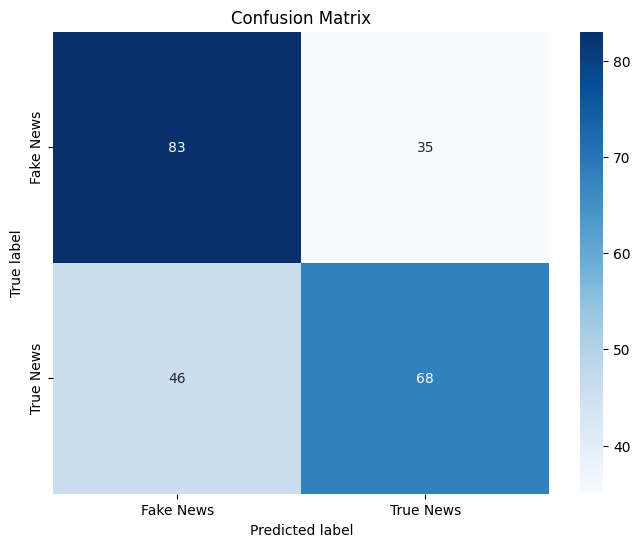

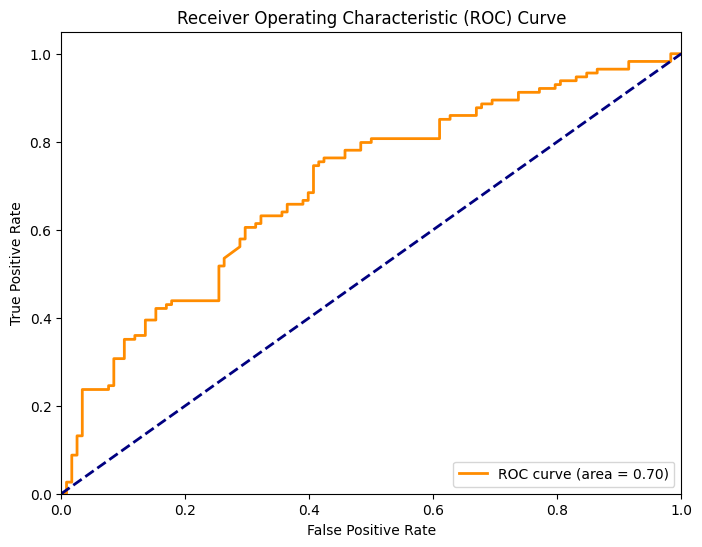

In [38]:
# SVM with Polynomial kernel
svm_poly = SVC(kernel='poly', probability=True, C=10000, degree=2)
svm_poly.fit(X_train, y_train)
predictions_poly = svm_poly.predict(X_test)
accuracy_poly = accuracy_score(y_test, predictions_poly)
print(f'Accuracy (SVM with polynomial kernel): {accuracy_poly:.2f}')
print('Classification Report (SVM with polynomial kernel):')
print(classification_report(y_test, predictions_poly))

makePlots(y_test, predictions_poly, X_test, svm_poly.predict_proba)

Accuracy (Naive Bayes): 0.74
Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       108
           1       0.77      0.73      0.75       124

    accuracy                           0.74       232
   macro avg       0.74      0.74      0.74       232
weighted avg       0.74      0.74      0.74       232

Confusion Matrix:
[[81 27]
 [33 91]]


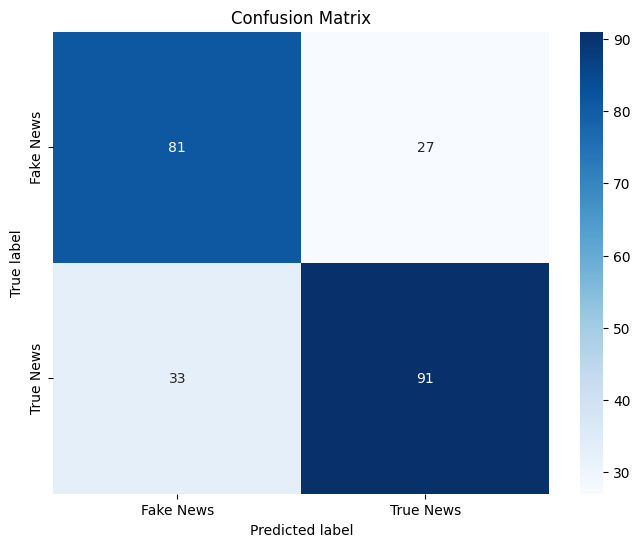

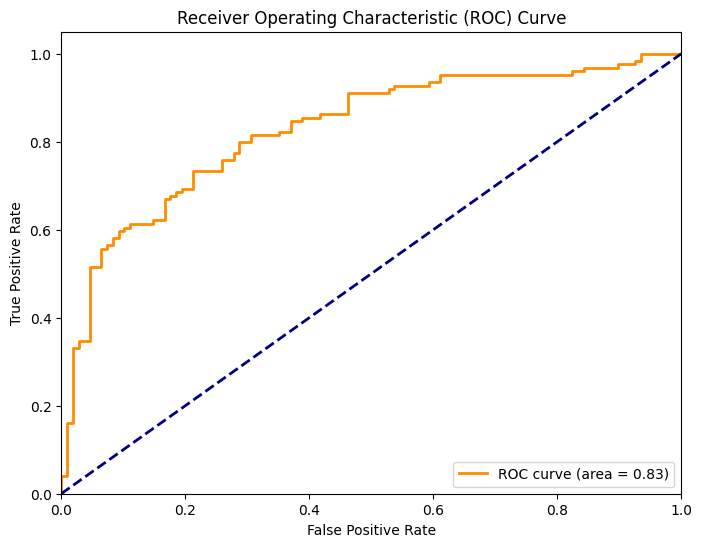

In [ ]:
# Naive Bayes classifier (Gaussian Naive Bayes for continuous features)
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Predictions and evaluation
predictions_nb = nb_classifier.predict(X_test)
accuracy_nb = accuracy_score(y_test, predictions_nb)
print(f'Accuracy (Naive Bayes): {accuracy_nb:.2f}')
print('Classification Report (Naive Bayes):')
print(classification_report(y_test, predictions_nb))

makePlots(y_test, predictions_nb, X_test, nb_classifier.predict_proba)

Accuracy (AdaBoost): 0.81
Classification Report (AdaBoost):
              precision    recall  f1-score   support

           0       0.78      0.83      0.81       108
           1       0.85      0.80      0.82       124

    accuracy                           0.81       232
   macro avg       0.81      0.82      0.81       232
weighted avg       0.82      0.81      0.81       232

Confusion Matrix:
[[90 18]
 [25 99]]


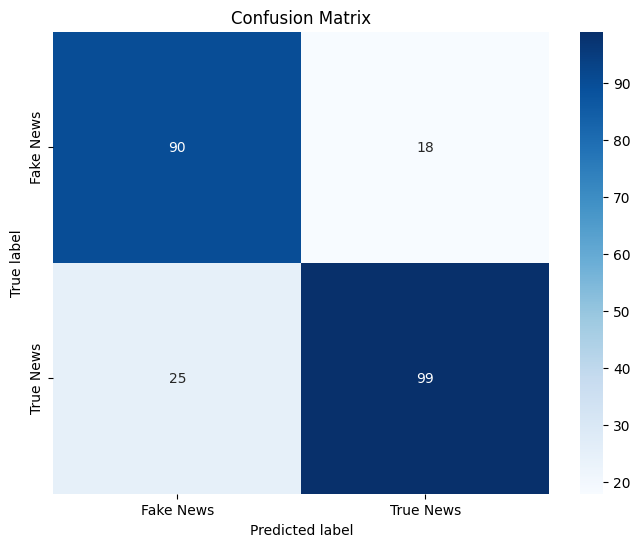

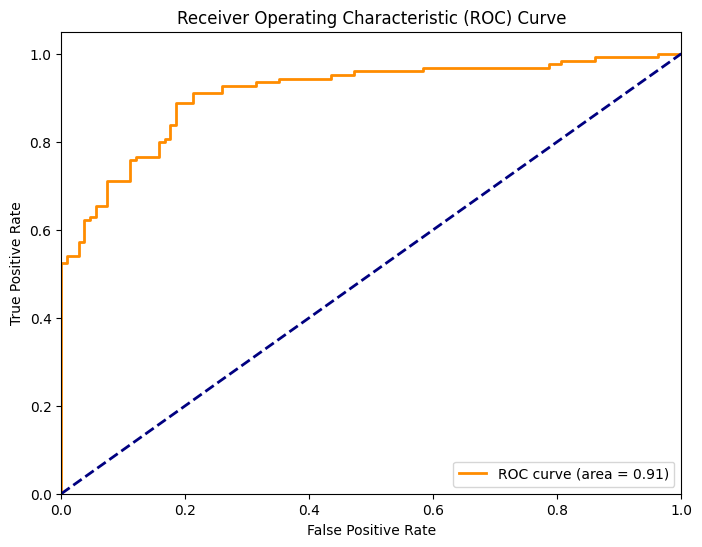

In [ ]:
# AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_classifier.fit(X_train, y_train)

# Predictions and evaluation
predictions_adaboost = adaboost_classifier.predict(X_test)
accuracy_adaboost = accuracy_score(y_test, predictions_adaboost)
print(f'Accuracy (AdaBoost): {accuracy_adaboost:.2f}')
print('Classification Report (AdaBoost):')
print(classification_report(y_test, predictions_adaboost))

makePlots(y_test, predictions_adaboost, X_test, adaboost_classifier.predict_proba)

Accuracy: 0.80
Accuracy (KNN): 0.80
Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.76      0.83      0.80       108
           1       0.84      0.77      0.81       124

    accuracy                           0.80       232
   macro avg       0.80      0.80      0.80       232
weighted avg       0.81      0.80      0.80       232

Confusion Matrix:
[[90 18]
 [28 96]]


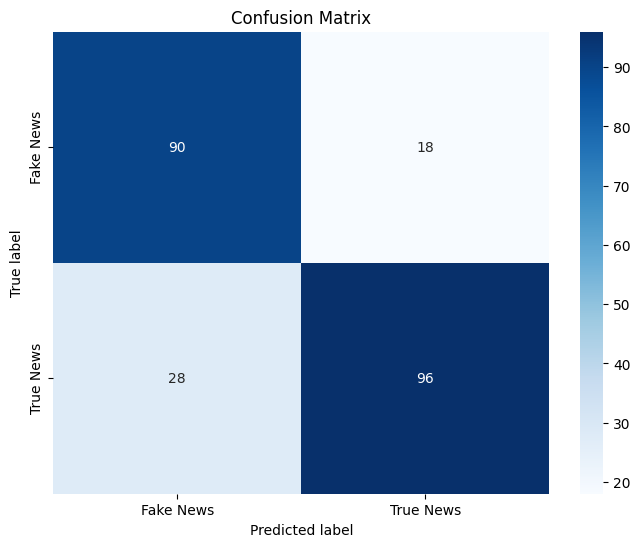

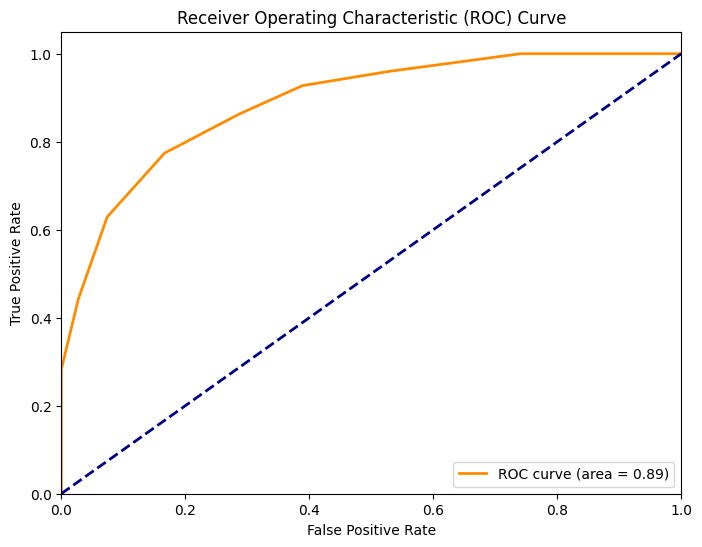

In [ ]:
#KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=10)
knn_classifier.fit(X_train, y_train)

# Predictions and evaluation
predictions_KNN = knn_classifier.predict(X_test)
accuracy_KNN = accuracy_score(y_test, predictions_KNN)
print(f'Accuracy: {accuracy_KNN:.2f}')
print(f'Accuracy (KNN): {accuracy_KNN:.2f}')
print('Classification Report (KNN):')
print(classification_report(y_test, predictions_KNN))

makePlots(y_test, predictions_KNN, X_test, knn_classifier.predict_proba)

Accuracy: 0.85
Accuracy (Logistical Regression): 0.85
Classification Report (Logistical Regression):
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       108
           1       0.89      0.81      0.85       124

    accuracy                           0.85       232
   macro avg       0.85      0.85      0.85       232
weighted avg       0.85      0.85      0.85       232

Confusion Matrix:
[[ 96  12]
 [ 23 101]]


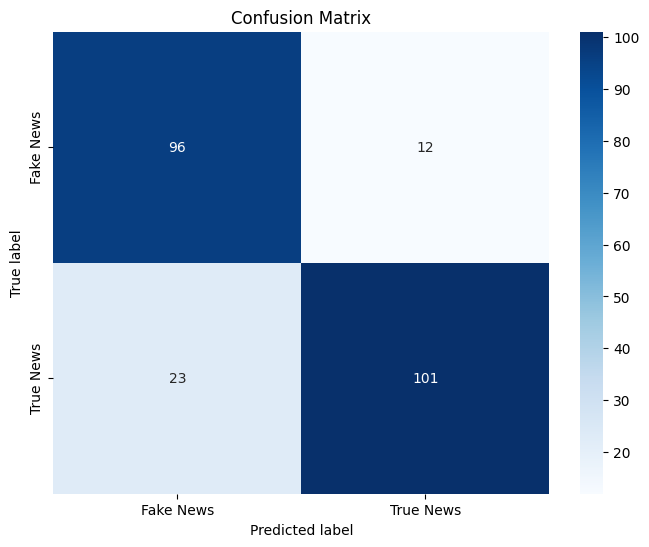

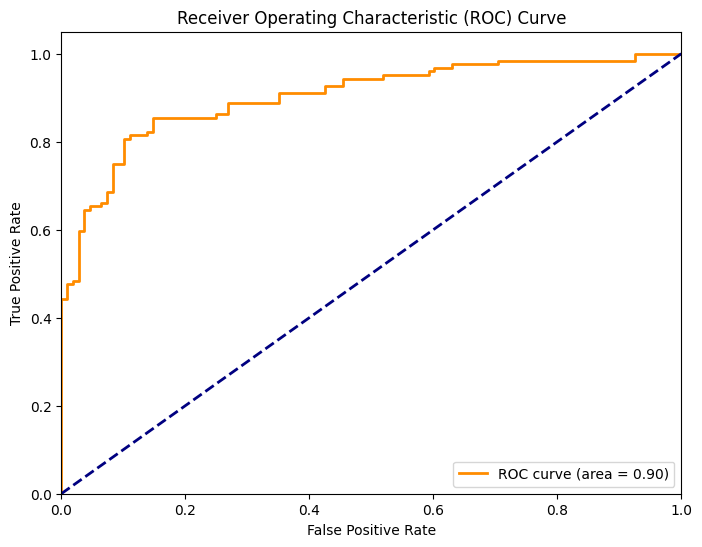

In [ ]:
#Logistical Regression Classifier
logistic_regression = LogisticRegression(max_iter=1000000)
logistic_regression.fit(X_train, y_train)

# Predictions and evaluation
predictions_log = logistic_regression.predict(X_test)
accuracy_log = accuracy_score(y_test, predictions_log)
print(f'Accuracy: {accuracy_log:.2f}')
print(f'Accuracy (Logistical Regression): {accuracy_log:.2f}')
print('Classification Report (Logistical Regression):')
print(classification_report(y_test, predictions_log))

makePlots(y_test, predictions_log, X_test, logistic_regression.predict_proba)